## Consume estimator

The objective of this additional notebook is to build a neural network aimed at predicting the missing values from the column 'Emissions' of the original dataset.

##### Imports

In [1]:
import sys
sys.path.insert(0, '../')
from core_functions import *
from pandas import set_option
pd.options.display.max_columns = None
import warnings
warnings.filterwarnings("ignore")

#### Load data

We load our dataset.

In [2]:
# Load dataset
df = pd.read_csv('../data/auto_price.csv', sep=',')

#### Preprocess our data

##### Consume column

Thanks to the above function we extract the numerical value from the 'Consume' column.

In [3]:
consume_df = df[['Consume', 'ConsumeFuel', 'ConsumeFuelNotUrban']].copy() # Build a sub-dataset containing only the columns relevant for this scenario
consume_df['MeanConsume'] = np.nan # Add the column for the mean consumption and fill it with nan
consume_df

,Consume,ConsumeFuel,ConsumeFuelNotUrban,MeanConsume
0,4.1,4.1,3.6,NaN
1,7.2,7.2,5.6,NaN
2,3.8,3.8,3.3,NaN
3,5.9,5.9,5.5,NaN
4,6.2,6.2,5.7,NaN
...,...,...,...,...
178243,4.1,4.1,3.7,NaN
178244,4.1,4.1,3.7,NaN
178245,3.8,3.8,3.4,NaN
178246,3.8,3.8,3.4,NaN


In [4]:
consume_df['Consume'] = consume_df['Consume'].apply(consume_numerizer)
consume_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178248 entries, 0 to 178247
Data columns (total 4 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Consume              131811 non-null  float64
 1   ConsumeFuel          123753 non-null  float64
 2   ConsumeFuelNotUrban  124041 non-null  float64
 3   MeanConsume          0 non-null       float64
dtypes: float64(4)
memory usage: 5.4 MB


In [5]:
for index, row in consume_df.iterrows():
    # row['Consume']
    # row['ConsumeFuel']
    # row['ConsumeFuelNotUrban']
    general = False
    urban = False
    uotUrban = False
    
    values = list()

    if not isnan(row['Consume']):
        general = True
        values.append(row['Consume'])

    if not isnan(row['ConsumeFuel']):
        urban = True
        values.append(row['ConsumeFuel'])

    if not isnan(row['ConsumeFuelNotUrban']):
        notUrban = True
        values.append(row['ConsumeFuelNotUrban'])

    mode = check_consume_row(general, urban, notUrban)
    if len(values) != 0:
        inferred_consumption = compute_consume(values, mode)
        consume_df.loc[index, 'MeanConsume'] = inferred_consumption

In [6]:
df['Consume'] = consume_df['MeanConsume'] # assign the new column to the original dataframe
df.drop(['ConsumeFuel', 'ConsumeFuelNotUrban'], axis=1, inplace=True)

We now build a sub-dataframe, with all the columns that could be useful for our scope.

In [7]:
consume_df = df[['MatriculationYear', 'cv', 'Engine', 'Emissions', 'Consume', 'EmissionClass']].copy()

##### EmissionClass column

Thanks to the snippet below, we estimate the emission class of each car in the dataset, and fill the relative column.

In [8]:
for idx, row in consume_df.iterrows():
    if type(row['EmissionClass'])!=str:
        inferred_emission_class = check_emission_class(row['EmissionClass'], row['MatriculationYear'])
        consume_df.loc[idx, 'EmissionClass'] = inferred_emission_class
consume_df.isna().sum()

MatriculationYear        0
cv                   11315
Engine                8350
Emissions            55438
Consume              45658
EmissionClass            0
dtype: int64

Map the categorical values in reversed order. The assumption is that a higher class implies a lower emission value.

In [9]:
emission_map = {'Euro 0':6, 'Euro 1':5, 'Euro 2':4, 'Euro 3':3, 'Euro 4':2, 'Euro 5':1, 'Euro 6':0}
consume_df['EmissionClass'] = consume_df['EmissionClass'].map(emission_map).astype('int')

##### 'CV' (HorsePower) and 'Engine' columns: Outlier detection

Now that the NaN inside the 'cv' column are gone, we can go on with the analysis of the outliers, and their deletion. In order to perform this operation, I will use the Interquartile Range (IQR), as follows.

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    6.35
Engine                4.68
Emissions            31.10
Consume              25.61
EmissionClass         0.00
dtype: float64 


Old Shape:  (178248, 6)


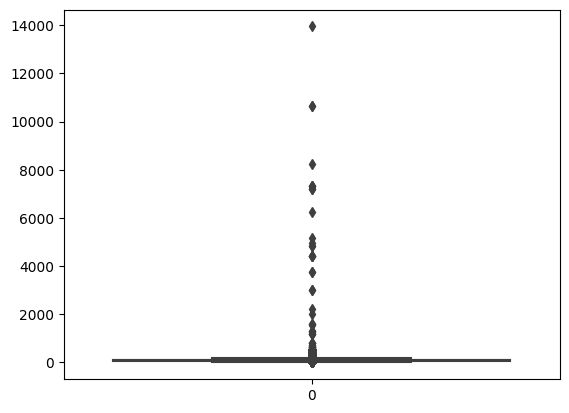

New Shape:  (162756, 6)


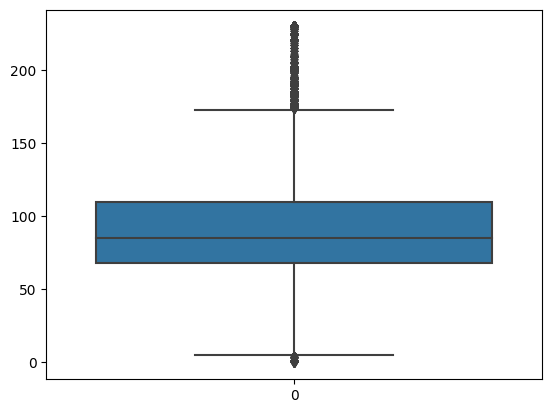

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                4.00
Emissions            26.37
Consume              20.61
EmissionClass         0.00
dtype: float64 


We lost the 8.69% of the initial observations.


In [10]:
outliers_deletion(consume_df, 'cv')

Let's filter out all the values equal or lower than 1cv, because I personally think these are errors, while for higher cv I cannot be so sure, so I will keep them.

In [11]:
threshold = 1
# create a boolean mask of rows to keep
mask = consume_df['cv'] > threshold
# apply the mask to the dataframe
consume_df = consume_df[mask]

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                3.84
Emissions            26.19
Consume              20.42
EmissionClass         0.00
dtype: float64 


Old Shape:  (162309, 6)


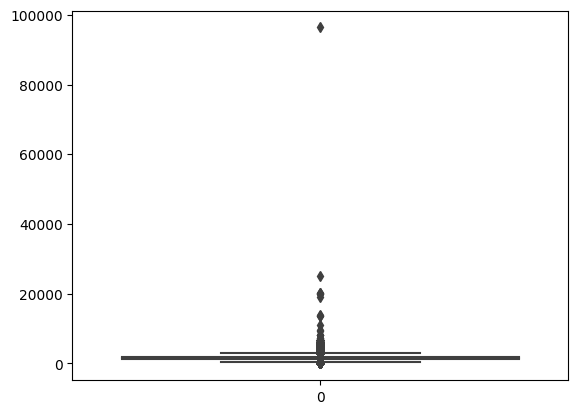

New Shape:  (155526, 6)


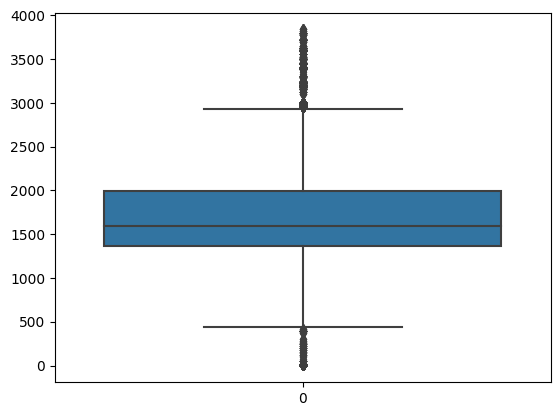

The percentage of missing values is the following: 

 MatriculationYear     0.00
cv                    0.00
Engine                0.00
Emissions            24.50
Consume              17.47
EmissionClass         0.00
dtype: float64 


We lost the 12.75% of the initial observations.


In [12]:
outliers_deletion(consume_df, 'Engine')

Let's also filter out all the values below 50 for the Engine.

In [13]:
threshold = 50
# create a boolean mask of rows to keep
mask = consume_df['Engine'] >= threshold
# apply the mask to the dataframe
consume_df = consume_df[mask]

For the consume column, the IQR seems not to be a good way.</br
Seen that there are some definitely too high values (such a consume of 6000l/km) and that the mean is around 5, by using the IQR method we would likely remove also values such as 12l/100km, which is a pretty standard value that doesn't need to be deleted.</br>
In order to solve this problem, I will manually define a threshold, over which all values are likely to be errors.

In [14]:
too_high_consume = set()
for idx, row in consume_df.iterrows():
    if row['Consume'] > 25:
        too_high_consume.add(row['Consume'])
print(too_high_consume)

{100.0, 38.0, 71.0, 42.0, 108.0, 45.0, 400.0, 48.0, 6000.0, 51.0, 84.0, 55.0, 312.0, 61.0}


According to some tests done with the script above, I have decided to use a threshold of 25l/100km as my max.

In [15]:
threshold = 25
# create a boolean mask of rows to keep
mask = consume_df['Consume'] <= threshold
# apply the mask to the dataframe
consume_df = consume_df[mask]

Now, let's build the final dataframe.

In [16]:
final_df = consume_df[['cv', 'Engine', 'Consume']].copy()

#### Prepare for training

We drop the rows containing NaN values.

In [17]:
final_df = final_df.dropna()

Split into feature and target dataset.

In [18]:
X = final_df[['cv', 'Engine']]
y = final_df['Consume']

print(X.shape, y.shape)

(124103, 2) (124103,)


We scale the features' dataset thanks to the sklearn.StandardScaler.

In [19]:
standard_scaler = preprocessing.StandardScaler()
X = standard_scaler.fit_transform(X)

In [20]:
X

array([[-0.25305931,  0.63456842],
       [-0.53803152, -0.23380748],
       [-0.39554541, -0.52471341],
       ...,
       [-0.25305931, -0.44873052],
       [-0.25305931, -0.44873052],
       [ 0.45937121,  0.63456842]])

Split into training and test dataset.

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

In [22]:
# Shapes of our data
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(83149, 2) (83149,)
(40954, 2) (40954,)


#### Neural Network Model

We build two callback functions:
- <b>earlystopping</b> is aimed at interrupting the training if the model stops learning. Additionally, it saves the best weight configuration reached during training;
- <b>reduce_lr</b> is useful to define a dynamic learning rate for our model. The lr is reduced when the model gets stuck on a plateu during training.

In [23]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="auto", patience = 12, 
                                        restore_best_weights = True)

reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                        patience=6, min_lr=0.0000001)

We build our NN model. The model is not too complex, but reasonably deep, and with some skip connections. As you can see, it is made up of mainly dense layers, the loss function used to train it is the MAE (Mean Absolute Error), but the metric we look at is the MSE (Mean Squared Error), to have a grasp on the capability of generalizing results. Reaching a low MAE value is per-se a finish line for the training, in particular if it is accompanied by a relatively low MSE value.</br>
Since the initial drafts where overfitting, I have added a Dropout layer with probability 0.2.

In [24]:
######################################
# Model Name = consume_estimator
######################################

# Define optimizer and initial learning rate
optimizer = Adam(learning_rate=0.01) # The initial learning rate is pretty high, but it gets dynamically decreased during training steps

input_layer = Input(shape=(2,))

# Define Hidden layers
first_dense_layer = Dense(4, activation='swish')(input_layer) # was swish 16
second_dense_layer = Dense(4, activation = 'relu')(input_layer) # was selu 16
concatenated_layer = concatenate([first_dense_layer, second_dense_layer])

final_dense_layer = Dense(4, activation = 'selu')(concatenated_layer) # 4

# Output Dense layer
output = Dense(1, activation='relu')(final_dense_layer)

# Build and compile the model
consume_estimator = Model(inputs=input_layer, outputs=output)
consume_estimator.compile(optimizer=optimizer, loss='mae', metrics=['mse'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-03-22 00:39:28.506228: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-22 00:39:28.506390: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Here we print out a summary of our model.

In [25]:
consume_estimator.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense (Dense)                  (None, 4)            12          ['input_1[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 4)            12          ['input_1[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 8)            0           ['dense[0][0]',                  
                                                                  'dense_1[0][0]']            

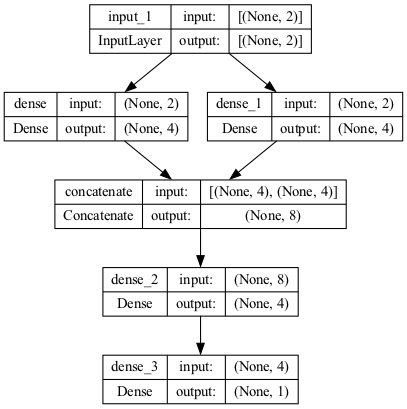

In [26]:
plot_model(consume_estimator, show_shapes=True, dpi=76)

#### Training

We define some hyper-parameters for the training.

In [27]:
batchsize = 128
epochs = 100
steps_per_epoch = 1000 
validation_steps = 500 

Effective training.

In [28]:
# Training record
################################################################################

history = consume_estimator.fit(X_train,
                            y_train,
                            steps_per_epoch=steps_per_epoch, 
                            validation_split=0.2, 
                            epochs=epochs,
                            shuffle=True, 
                            callbacks =[reduce_lr, earlystopping])

Epoch 1/100


2023-03-22 00:39:29.090555: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-22 00:39:29.338596: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 999/1000 [============================>.] - ETA: 0s - loss: 0.8775 - mse: 1.8107

2023-03-22 00:39:39.176024: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1000/1000 [==============================] - 12s 12ms/step - loss: 0.8773 - mse: 1.8098 - val_loss: 0.7646 - val_mse: 1.2966 - lr: 0.0100
Epoch 2/100
1000/1000 [==============================] - 11s 11ms/step - loss: 0.7645 - mse: 1.3386 - val_loss: 0.7408 - val_mse: 1.2358 - lr: 0.0100
Epoch 3/100
1000/1000 [==============================] - 12s 12ms/step - loss: 0.7545 - mse: 1.3283 - val_loss: 0.7341 - val_mse: 1.2059 - lr: 0.0100
Epoch 4/100
1000/1000 [==============================] - 12s 12ms/step - loss: 0.7450 - mse: 1.3013 - val_loss: 0.7276 - val_mse: 1.2278 - lr: 0.0100
Epoch 5/100
1000/1000 [==============================] - 12s 12ms/step - loss: 0.7425 - mse: 1.2960 - val_loss: 0.7267 - val_mse: 1.2372 - lr: 0.0100
Epoch 6/100
1000/1000 [==============================] - 12s 12ms/step - loss: 0.7449 - mse: 1.3069 - val_loss: 0.7387 - val_mse: 1.1898 - lr: 0.0100
Epoch 7/100
1000/1000 [==============================] - 12s 12ms/step - loss: 0.7408 - mse: 1.2951 - val_loss: 

As we can see, both the values of the MSE (around 1) and MAE (around .6 points) are discretely low. Even in this case, this is a better solution for column completion than the mean or median imputation.

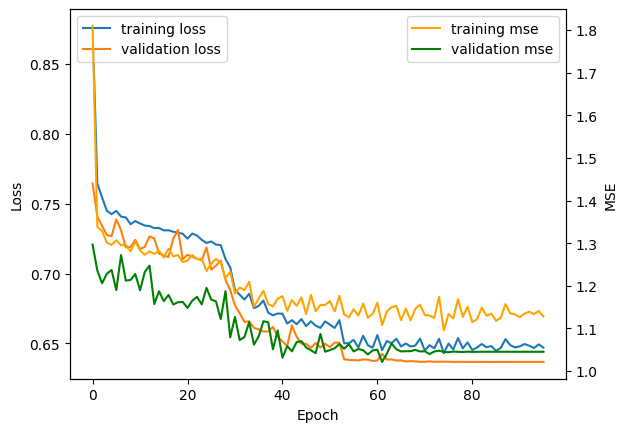

In [29]:
plot_training_history(history)

Let's save the model.

In [30]:
consume_estimator.save("models/consume_estimator_2dim")

INFO:tensorflow:Assets written to: models/consume_estimator_2dim/assets


### Test

The aim of this section is to test our model against the test_set (that it has never seen), in order to have a clearer idea about the performances.

In [31]:
estimator = keras.models.load_model("models/consume_estimator_2dim")

In [35]:
np.array(X_test)[1]

array([-0.39554541, -0.52471341])

In [38]:
np.array(y_test)[2]

4.5

In [39]:
prediction = estimator.predict(X_test)
prediction[2]

1280/1280 [==============================] - 4s 3ms/step


array([4.1000347], dtype=float32)